In [120]:
from __future__ import print_function
import keras
import os
import json
import matplotlib.pyplot as plt
import datetime
from keras.datasets import cifar10
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from time import time
from keras.callbacks import TensorBoard


from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

import boto
import boto.s3
import sys
from boto.s3.key import Key
import glob

In [121]:
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

In [122]:
# Create logfile.
logfile = open("logs/Cifar10_CNN.log", "a")
def log_entry(s):
    #print('Date now: %s' % datetime.datetime.now())

    timestamp = '[%s] : ' % datetime.datetime.now()
    log_line = timestamp + s + '\n'
    logfile.write(log_line)
    logfile.flush()

In [123]:
def parseFloat(x):
    try:
        x = float(x)
    except:
        x = 0
        log_entry("Unable to conveert ot float")
    return x

def convertToInt(x):
    try:
        x = int(x)
    except:
        x = 0
        log_entry("Unable to conveert ot int")
    return x

In [124]:
import os
import zipfile

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))

In [125]:
#read parameters from config file
with open('config/config.json') as json_file:    
        json_data = json.load(json_file)

log_entry("Json file loaded")

In [126]:
batch_size = convertToInt(json_data["batch_size"])
num_classes = convertToInt(json_data["num_classes"])
epochs = convertToInt(json_data["epochs"])
data_augmentation = json_data["data_augmentation"]
num_predictions = convertToInt(json_data["num_predictions"])
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'
team_number = 'team3_'
optimizer = json_data["optimizer"]
learning_rate = convertToInt(json_data["learning_rate"])
loss = json_data["loss"]
AWS_ACCESS_KEY_ID = json_data["AWS_ACCESS_KEY_ID"]
AWS_SECRET_ACCESS_KEY = json_data["AWS_SECRET_ACCESS_KEY"]

In [127]:
# The data, shuffled and split between train and test sets:
log_entry("Loading dataset")
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [128]:
# Convert class vectors to binary class matrices.
log_entry("Convert class vectors to binary class matrices")
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [129]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [130]:
# Define the model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Convolution2D(48, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3))`


In [131]:
model.add(Convolution2D(96, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Conv2D(96, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), padding="same")`
  if __name__ == '__main__':
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
  app.launch_new_instance()


In [132]:
model.add(Convolution2D(192, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Conv2D(192, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3), padding="same")`
  if __name__ == '__main__':
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3))`
  app.launch_new_instance()


In [133]:
model.add(Flatten())
model.add(Dense(512,
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [134]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [135]:
tensorboard = TensorBoard(log_dir="logs/{}".format(time()),histogram_freq=0,write_graph=True, write_images=True)



log_entry("Starting model train")

model_info = model.fit(x_train, y_train, 
                       batch_size=batch_size, nb_epoch=epochs, 
                       validation_data = (x_test, y_test), 
                       verbose=0,  callbacks=[tensorboard])

log_entry("Model training done")

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


In [136]:
history_dict = model_info.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

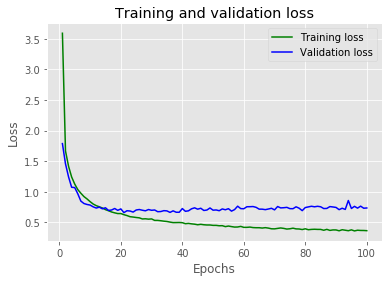

In [137]:
acc = model_info.history['acc']
val_acc = model_info.history['val_acc']
loss = model_info.history['loss']
val_loss = model_info.history['val_loss']

epochs = range(1, len(acc) + 1)

# "g" is for "blue dot"
plt.plot(epochs, loss, 'g', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

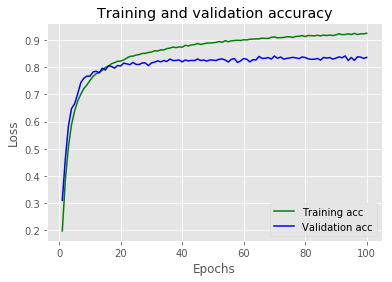

In [138]:

plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [139]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /home/ubuntu/ssl/saved_models/keras_cifar10_trained_model.h5 


In [140]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 2s 223us/step
Test loss: 0.734770066690445
Test accuracy: 0.8365
